# Deep Learning & Applied AI

We reccomend to go through the notebook using Google Colaboratory.

# Tutorial 6: Convolutional neural networks

In this tutorial, we will cover:

- Convolutional neural networks
- Residual networks

Our info:

- Dr. Luca Moschella (moschella@di.uniroma1.it)
- Dr. Marco Fumero (fumero@di.uniroma1.it)

Course:

- Website and notebooks will be available at [DLAI-s2-2023](https://github.com/erodola/DLAI-s2-2023/)

##Import dependencies (run the following cells)

In [1]:
!pip install plotly==5.3.1

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 23.9/23.9 MB 29.2 MB/s eta 0:00:00
  Attempting uninstall: plotly
    Found existing installation: plotly 5.13.1
    Uninstalling plotly-5.13.1:
      Successfully uninstalled plotly-5.13.1


In [2]:
# @title import dependencies

from typing import Mapping, Union, Optional

import numpy as np
import argparse
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import plotly.graph_objects as go
import torchvision
from torchvision import datasets, models, transforms
import os
from tqdm.notebook import tqdm

from __future__ import print_function, division

In [3]:
# @title reproducibility stuff

import random
torch.manual_seed(42)
np.random.seed(42)
random.seed(0)

torch.cuda.manual_seed(0)
torch.backends.cudnn.deterministic = True  # Note that this Deterministic mode can have a performance impact
torch.backends.cudnn.benchmark = False

##Intro

Today we start going back to March 2016. 

Do you remember this match?

![AlphaGo](https://mediad.publicbroadcasting.net/p/shared/npr/201805/470700854.jpg)



For the first time an artificial intelligence defeated a Go world champion, Lee Sedol, a feat that was previously believed to be at least a decade away. 
This event is already a milestone in AI research.

A fundamental ingredient of AlphaGo was a neural network architecture that at that time was already revolutionizing the field of computer vision; Convolutional Neural Networks.

The huge complexity of the patterns on a Go board was caught with success using the same general priors proved to be effective in classifying real world images.


Today we will explore this architecture and one of its evolution, Residual Convolutional Neural Networks, the one used in AlphaGo.

If you want to re-experience the AI conquer of the most ancient of games, a very nice documentary about that match is now [free on YouTube](https://www.youtube.com/watch?v=WXuK6gekU1Y)!



##CNNs: a fundamental idea at the core of deep learning

Convolutional neural networks are a way of exploiting a known prior about our problem. Actually, a whole set of priors at the same time:
- Translational equivariance
- Compositionality
- Locality
- Self-similarity

> **EXERCISE**: Consider the problem of recognizing objects in images. Looking at the following example, discuss how all these priors apply.
> 
>![polyfit matrix notation](https://drive.google.com/uc?export=view&id=1SLeKcN9EAYhy98aaPjxfS7uRyypSSwKS)

In [4]:
# @title Solution 👀
# """
# - Translational equivariance: A book upper left is still a book down right.
# - Compositionality: The table is composed by legs, recognizing the legs helps in recognizing the table
# - Locality: To recognize an eye you need only pixels locally concentrated in a spot on the image.
# - Self-similarity: You can recognize the two eyes using a single eye-recognizer
# """

>Think about the convolution operation as a **fundamental idea at the core of deep learning** more than a nice trick to exploit known but not essential priors.

These priors are so general and training a deep MLP is so hard that a large part of deep learning applications would be not possible without CNNs.




## Convolutional Neural Networks in practice

Building a CNN today is very easy thanks to modern deep learning programming frameworks. As you have seen in the last notebook, the `torch.nn` package reduces the introduction of a convolution transformation to a single call to a function  (e.g. ```nn.Conv2d```  for 2D data). 

Nevertheless, CNNs involve many different operations and non-trivial changing in shape of the input tensor through the layers. 

Keep in mind the two basic transformations introduced by CNNs:
- Convolution 

![conv](https://upload.wikimedia.org/wikipedia/commons/1/19/2D_Convolution_Animation.gif)
- Pooling (Max pooling in the example below)

![pooling](https://upload.wikimedia.org/wikipedia/commons/e/e9/Max_pooling.png)

*Images from Wikipedia*



---

**Under the hood: how does a convolution work?**

Let's compute by hand a single output value of a convolution operation.

Altough simple to explain intuitively, managing and understanding how the *dimensions* involved behave in the computation can be **outstandingly** confusing.


In [5]:
# Define an arbitrary input tensor, i.e.: [batch, channels, w, h]
batch_size, num_channels, width, height = 1, 2, 4, 4
a = torch.arange(batch_size * num_channels * width * height).reshape(batch_size, num_channels, width, height).float()
a, a.shape

(tensor([[[[ 0.,  1.,  2.,  3.],
           [ 4.,  5.,  6.,  7.],
           [ 8.,  9., 10., 11.],
           [12., 13., 14., 15.]],
 
          [[16., 17., 18., 19.],
           [20., 21., 22., 23.],
           [24., 25., 26., 27.],
           [28., 29., 30., 31.]]]]),
 torch.Size([1, 2, 4, 4]))

In [6]:
# Define a convolution
c = nn.Conv2d(in_channels=2, out_channels=3, kernel_size=2, bias=False)
c

Conv2d(2, 3, kernel_size=(2, 2), stride=(1, 1), bias=False)

In [7]:
# Let's look under the hood... somewhere there must be learnable weights...
# They have shape [3, 2, 2, 2], i.e.: [out, in, kernel, kernel]
c.weight, c.weight.shape

(Parameter containing:
 tensor([[[[ 0.2703,  0.2935],
           [-0.0828,  0.3248]],
 
          [[-0.0775,  0.0713],
           [-0.1721,  0.2076]]],
 
 
         [[[ 0.3117, -0.2594],
           [ 0.3073,  0.0662]],
 
          [[ 0.2612,  0.0479],
           [ 0.1705, -0.0499]]],
 
 
         [[[ 0.2725,  0.0523],
           [-0.1651,  0.0901]],
 
          [[-0.1629, -0.0415],
           [-0.1436,  0.2345]]]], requires_grad=True),
 torch.Size([3, 2, 2, 2]))

In [8]:
# We define custom kernel weights for the first out channel
# In this way we can easily reproduce the computation
my_custom_2dkernel_in_channel1 = torch.tensor([[ .1, .2], [-.4, -.5, ]])
my_custom_2dkernel_in_channel2 = torch.tensor([[.4, .3], [-.42, -.45, ]])

In [9]:
my_custom_2dkernel_in_channel1, my_custom_2dkernel_in_channel1.shape

(tensor([[ 0.1000,  0.2000],
         [-0.4000, -0.5000]]),
 torch.Size([2, 2]))

In [10]:
my_custom_2dkernel_in_channel2, my_custom_2dkernel_in_channel2.shape

(tensor([[ 0.4000,  0.3000],
         [-0.4200, -0.4500]]),
 torch.Size([2, 2]))

In [13]:
# Modify the weights of the convolution

# out-channel 0, in-channel 0
c.weight.data[0, 0, ...] = my_custom_2dkernel_in_channel1

# out-channel 0, in-channel 1
c.weight.data[0, 1, ...] = my_custom_2dkernel_in_channel2

# ...accessing directly the .data attribute of a tensor by-passed some safety checks.
# Try to modify directly the tensor contained in weight!

In [14]:
# First out-channel correctly set!
c.weight, c.weight.shape

(Parameter containing:
 tensor([[[[ 0.1000,  0.2000],
           [-0.4000, -0.5000]],
 
          [[ 0.4000,  0.3000],
           [-0.4200, -0.4500]]],
 
 
         [[[ 0.3117, -0.2594],
           [ 0.3073,  0.0662]],
 
          [[ 0.2612,  0.0479],
           [ 0.1705, -0.0499]]],
 
 
         [[[ 0.2725,  0.0523],
           [-0.1651,  0.0901]],
 
          [[-0.1629, -0.0415],
           [-0.1436,  0.2345]]]], requires_grad=True),
 torch.Size([3, 2, 2, 2]))

In [15]:
# Did you notice?
# We set `kernel_size=2` to our nn.Conv2d, i.e. we have a 2x2 kernel...
#
# ...for each input channel! 
# ...for each output channel! (we will consider a single out-channel in this hardcoded unrolling for simplicity)

> **EXERCISE**
>
> Stop one second. Try to apply the convolution yourself! 
>
> This is the input tensor with shape `torch.Size([1, 2, 4, 4])`, i.e. `[batch, channels, w, h]`:
>
> ```python
> a = tensor([[[[ 0.,  1.,  2.,  3.],
>               [ 4.,  5.,  6.,  7.],
>               [ 8.,  9., 10., 11.],
>               [12., 13., 14., 15.]],
>     
>              [[16., 17., 18., 19.],
>               [20., 21., 22., 23.],
>               [24., 25., 26., 27.],
>               [28., 29., 30., 31.]]]])
> ```
>
> This is the kernel tensor with shape `torch.Size([3, 2, 2, 2])`, i.e. `[out_channels, in_channels, kernel_size, kernel_size]`:
>
> ```python
> c.weight = tensor([[[[ 0.1000,  0.2000],
>                      [-0.4000, -0.5000]],
>            
>                     [[ 0.4000,  0.3000],
>                      [-0.4200, -0.4500]]],
>            
>            
>                    [[[-0.3517,  0.2366],
>                      [ 0.2679,  0.1289]],
>            
>                     [[-0.2465, -0.3489],
>                      [-0.2871,  0.2636]]],
>            
>            
>                    [[[ 0.1697,  0.2975],
>                      [ 0.1852,  0.0895]],
>            
>                     [[-0.0035, -0.2689],
>                      [-0.3029, -0.3307]]]], requires_grad=True)
> ```
>
> Which value will be in `output[0, 0, 0, 0]`, i.e. the first element of the output tensor after the convolution? 

In [16]:
# This is the result when we apply this convolution...
o = c(a)
o, o.shape

(tensor([[[[-10.2500, -11.0200, -11.7900],
           [-13.3300, -14.1000, -14.8700],
           [-16.4100, -17.1800, -17.9500]],
 
          [[  8.6553,   9.5108,  10.3662],
           [ 12.0770,  12.9325,  13.7879],
           [ 15.4987,  16.3542,  17.2096]],
 
          [[ -1.4152,  -1.2788,  -1.1423],
           [ -0.8694,  -0.7329,  -0.5965],
           [ -0.3236,  -0.1871,  -0.0507]]]], grad_fn=<ConvolutionBackward0>),
 torch.Size([1, 3, 3, 3]))

In [17]:
# Let's compute the first value of the first out channel manually, i.e. this one:
o[0, 0, 0, 0]  # [batch, channels, w, h]

tensor(-10.2500, grad_fn=<SelectBackward0>)

In [18]:
# Take the first window of the same size of the kernel in the first in_channel of the input
f1 = a[0, 0, :2, :2]
f1

tensor([[0., 1.],
        [4., 5.]])

In [19]:
# And the second input channel
f2 = a[0, 1, :2, :2]
f2

tensor([[16., 17.],
        [20., 21.]])

In [20]:
# Perform a point-wise multiplication along the (input) feature dimension, between the input and the kernel.
# In this case this can be done manually in this way:

f = f1 * my_custom_2dkernel_in_channel1 + f2 * my_custom_2dkernel_in_channel2
f

tensor([[  6.4000,   5.3000],
        [-10.0000, -11.9500]])

In [21]:
# Sum up the result
s = f.sum()
s

tensor(-10.2500)

In [22]:
# i.e. the first element in the first out_channel of our output tensor
o

tensor([[[[-10.2500, -11.0200, -11.7900],
          [-13.3300, -14.1000, -14.8700],
          [-16.4100, -17.1800, -17.9500]],

         [[  8.6553,   9.5108,  10.3662],
          [ 12.0770,  12.9325,  13.7879],
          [ 15.4987,  16.3542,  17.2096]],

         [[ -1.4152,  -1.2788,  -1.1423],
          [ -0.8694,  -0.7329,  -0.5965],
          [ -0.3236,  -0.1871,  -0.0507]]]], grad_fn=<ConvolutionBackward0>)

> **EXERCISE**
>
> How many parameters does this layer have?
>
> ```python
> nn.Conv2d(in_channels=5, out_channels=10, kernel_size=2, bias=True)
> ```

In [23]:
#@title Solution 👀

# Decomment.
# c =  nn.Conv2d(in_channels=5, out_channels=10, kernel_size=2, bias=True)
# sum(x.numel() for x in c.parameters() if x.requires_grad)

# Can you explain the result?
# How big is the bias?

---



In this section we'll see how incorporating the right prior helps us, if they hold. If our assumptions are not true, they will bite us hard.

We need to make just the right amount of assumptions, not more than that.

In [24]:
# Just a function to count the number of parameters
def count_parameters(model: torch.nn.Module) -> int:
  """ Counts the number of trainable parameters of a module
  
  :param model: model that contains the parameters to count
  :returns: the number of parameters in the model
  """
  return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [25]:
# Define the device to use: use the gpu runtime if possible!
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}') 

Using device: cuda:0


### Load the dataset CIFAR-10
The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images.

We will use some PyTorch utilities to download, shuffle, normalize the data and arrange it in batches.


In [26]:
# Totally arbitrary transformations 
# You can do better! e.g. compute the mean and std of the train dataset
image_transforms = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        transforms.ToTensor(),
        transforms.Normalize(mean=(0.5,), std=(0.5,)),
    ]
)

train_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "../data",
        train=True,
        download=True,
        transform=image_transforms
    ),
    batch_size=64,
    shuffle=True,
)

test_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10(
        "../data",
        train=False,
        transform=image_transforms
    ),
    batch_size=1000,
    shuffle=True,
)

# Retrieve the image size and the number of color channels
x, _ = next(iter(train_loader))

n_channels = x.shape[1]
input_size_w = x.shape[2]
input_size_h = x.shape[3]
input_size = input_size_w * input_size_h

# Specify the number of classes in CIFAR10
output_size = 10  # there are 10 classes
output_classes = ('plane', 'car', 'bird', 'cat', 'deer', 
                  'dog', 'frog', 'horse', 'ship', 'truck')

100%|██████████| 170498071/170498071 [00:02<00:00, 66842547.34it/s]


Extracting ../data/cifar-10-python.tar.gz to ../data


In [27]:
# We can still access our dataset
train_loader.dataset

Dataset CIFAR10
    Number of datapoints: 50000
    Root location: ../data
    Split: Train
    StandardTransform
Transform: Compose(
               Grayscale(num_output_channels=1)
               ToTensor()
               Normalize(mean=(0.5,), std=(0.5,))
           )

In [32]:
# @title Dataset examples { run: "auto" }

import plotly.express as px

training_index = 11386  #@param {type:"slider", min:0, max:50000, step:1}
image, label = train_loader.dataset[training_index]

antbee_example = np.array(image[0])

fig = px.imshow(antbee_example, 
                title=output_classes[label],
                color_continuous_scale='gray', 
                color_continuous_midpoint=0)
fig.show()

### Define the model classes

We're going to compare the performance of a classic MLP model with a model that uses convolutions.

The models are defined as follows:

In [33]:
class FC2Layer(nn.Module):
    def __init__(
        self, input_size: int, input_channels: int, n_hidden: int, output_size: int
    ) -> None:
        """
        Simple MLP model

        :param input_size: number of pixels in the image
        :param input_channels: number of color channels in the image
        :param n_hidden: size of the hidden dimension to use
        :param output_size: expected size of the output
        """
        super().__init__()
        self.network = nn.Sequential(
            nn.Linear(input_size * input_channels, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, n_hidden),
            nn.ReLU(),
            nn.Linear(n_hidden, output_size),
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        :param x: batch of images with size [batch, 1, w, h]

        :returns: predictions with size [batch, output_size]
        """
        x = x.view(x.shape[0], -1)
        o = self.network(x)
        return o


class CNN(nn.Module):
    def __init__(
        self, input_size: int, input_channels: int, n_feature: int, output_size: int
    ) -> None:
        """
        Simple model that uses convolutions

        :param input_size: number of pixels in the image
        :param input_channels: number of color channels in the image
        :param n_feature: size of the hidden dimensions to use
        :param output_size: expected size of the output
        """
        super().__init__()
        self.n_feature = n_feature
        self.conv1 = nn.Conv2d(
            in_channels=input_channels, out_channels=n_feature, kernel_size=3
        )
        self.conv2 = nn.Conv2d(n_feature, n_feature, kernel_size=3)
        self.conv3 = nn.Conv2d(n_feature, n_feature, kernel_size=3)

        self.fc1 = nn.Linear(n_feature * 5 * 5, 10)
        self.fc2 = nn.Linear(10, 10)

    def forward(self, 
                x: torch.Tensor, 
                return_conv1: bool = False, 
                return_conv2: bool = False, 
                return_conv3: bool = False
        ) -> torch.Tensor:
        """
        :param x: batch of images with size [batch, 1, w, h]
        :param return_conv1: if True return the feature maps of the first convolution
        :param return_conv2: if True return the feature maps of the second convolution
        :param return_conv3: if True return the feature maps of the third convolution

        :returns: predictions with size [batch, output_size]
        """
        x = self.conv1(x)
        if return_conv1:
            return x
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = self.conv2(x)
        if return_conv2:
            return x
        x = F.relu(x)

        # Not so easy to keep track of shapes... right?
        # An useful trick while debugging is to feed the model a fixed sample batch
        # and print the shape at each step, just to be sure that they match your expectations.

        # print(x.shape)

        x = self.conv3(x)
        if return_conv3:
            return x
        x = F.relu(x)
        x = F.max_pool2d(x, kernel_size=2)

        x = x.view(x.shape[0], -1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

# A fixed sample batch
# x, _ = next(iter(train_loader))
# model = CNN(input_size, n_channels, 9, 10)
# _ = model(x)

### Training utility functions

Let's define some utility functions, we'll use them to simplify the training of different models on different datasets.

We will need:
- A function to permute the pixels of every image in a batch given a fixed permutation (this will be useful later for an experiment)
- One function to train the model and evaluate it

---

*Side note*: you should not memorize the code, just as you do not memorize formulas. You should be able to write it on your own after you understand what it does. Learn what it is possible to do, what should be possible to do and what you need, then... just search for the stuff you need in the docs, google or stackoverflow.

If you are troubled when solving algorithmic problems, you can have some fun with the computer science version of puzzle magazines: [LeetCode](https://leetcode.com/problemset/algorithms/).

![](https://imgs.xkcd.com/comics/wisdom_of_the_ancients.png)

In [34]:
# You can skip this cell and read only the function docstring

import torch
import torch.nn.functional as F
from typing import Optional, Callable, Dict
from tqdm.notebook import tqdm, trange


def permute_pixels(images: torch.Tensor, perm: Optional[torch.Tensor]) -> torch.Tensor:
    """ Permutes the pixel in each image in the batch

    :param images: a batch of images with shape [batch, channels, w, h]
    :param perm: a permutation with shape [w * h]

    :returns: the batch of images permuted according to perm
    """
    if perm is None:
        return images

    batch_size = images.shape[0]
    n_channels = images.shape[1]
    w = images.shape[2]
    h = images.shape[3]
    images = images.view(batch_size, n_channels, -1)
    images = images[..., perm]
    images = images.view(batch_size, n_channels, w, h)
    return images


def make_averager() -> Callable[[Optional[float]], float]:
    """ Returns a function that maintains a running average

    :returns: running average function
    """
    count = 0
    total = 0

    def averager(new_value: Optional[float]) -> float:
        """ Running averager

        :param new_value: number to add to the running average,
                          if None returns the current average
        :returns: the current average
        """
        nonlocal count, total
        if new_value is None:
            return total / count if count else float("nan")
        count += 1
        total += new_value
        return total / count

    return averager

def test_model(
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    perm: Optional[torch.Tensor] = None,
    device: str = "cuda",
) -> Dict[str, Union[float, Callable[[Optional[float]], float]]]:
    """Compute model accuracy on the test set

    :param test_dl: the test dataloader
    :param model: the model to train
    :param perm: if not None, permute the pixel in each image according to perm

    :returns: computed accuracy
    """
    model.eval()
    test_loss_averager = make_averager()  # mantain a running average of the loss
    correct = 0
    for data, target in test_dl:
        # send to device
        data, target = data.to(device), target.to(device)

        if perm is not None:
            data = permute_pixels(data, perm)

        output = model(data)

        test_loss_averager(F.cross_entropy(output, target))

        # get the index of the max probability
        pred = output.max(1, keepdim=True)[1]
        correct += pred.eq(target.view_as(pred)).cpu().sum().item()

    return {
        "accuracy": 100.0 * correct / len(test_dl.dataset),
        "loss_averager": test_loss_averager,
        "correct": correct,
    }

def fit(
    epochs: int,
    train_dl: torch.utils.data.DataLoader,
    test_dl: torch.utils.data.DataLoader,
    model: torch.nn.Module,
    opt: torch.optim.Optimizer,
    tag: str,
    perm: Optional[torch.Tensor] = None,
    device: str = "cuda",
) -> float:
    """Train the model and computes metrics on the test_loader at each epoch

    :param epochs: number of epochs
    :param train_dl: the train dataloader
    :param test_dl: the test dataloader
    :param model: the model to train
    :param opt: the optimizer to use to train the model
    :param tag: description of the current model
    :param perm: if not None, permute the pixel in each image according to perm

    :returns: accucary on the test set in the last epoch
    """
    for epoch in trange(epochs, desc="train epoch"):
        model.train()
        train_loss_averager = make_averager()  # mantain a running average of the loss

        # TRAIN
        tqdm_iterator = tqdm(
            enumerate(train_dl),
            total=len(train_dl),
            desc=f"batch [loss: None]",
            leave=False,
        )
        for batch_idx, (data, target) in tqdm_iterator:
            # send to device
            data, target = data.to(device), target.to(device)

            if perm is not None:
                data = permute_pixels(data, perm)

            output = model(data)
            loss = F.cross_entropy(output, target)
            loss.backward()
            opt.step()
            opt.zero_grad()

            train_loss_averager(loss.item())

            tqdm_iterator.set_description(
                f"train batch [avg loss: {train_loss_averager(None):.3f}]"
            )
            tqdm_iterator.refresh()

        # TEST
        test_out = test_model(test_dl, model, perm, device)

        print(
            f"Epoch: {epoch}\n"
            f"Train set: Average loss: {train_loss_averager(None):.4f}\n"
            f"Test set: Average loss: {test_out['loss_averager'](None):.4f}, "
            f"Accuracy: {test_out['correct']}/{len(test_dl.dataset)} "
            f"({test_out['accuracy']:.0f}%)\n"
        )
    models_accuracy[tag] = test_out['accuracy']
    return test_out['accuracy']



def get_model_optimizer(model: torch.nn.Module) -> torch.optim.Optimizer:
    """
    Encapsulate the creation of the model's optimizer, to ensure that we use the
    same optimizer everywhere

    :param model: the model that contains the parameter to optimize

    :returns: the model's optimizer
    """
    return optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    # return optim.SGD(model.parameters(), lr=0.01, momentum=0.1, weight_decay=1e-5)


Training hyperparameters:

In [35]:
# Define the number of the epochs
epochs = 4

# Number of hidden units for the MLP
n_hidden = 9 

# Number of the feature maps in the CNN
n_features = 6

# Define a dictionary that will contain the performance of the different models
models_accuracy = {}

#### CIFAR-10

In this section we will train our MLP and CNN on the train set of the CIFAR-10,
and evaluate them on the test set.

##### Small fully-connected network

In [36]:
model_fnn = FC2Layer(input_size, n_channels, n_hidden, output_size)
model_fnn.to(device)
optimizer = get_model_optimizer(model_fnn)

print(f'Number of parameters: {count_parameters(model_fnn)}')

fit(epochs=epochs, 
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_fnn,
    opt=optimizer, 
    tag='fnn',
    device=device)

Number of parameters: 9415


train epoch:   0%|          | 0/4 [00:00<?, ?it/s]

batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0
Train set: Average loss: 2.0700
Test set: Average loss: 1.9685, Accuracy: 2820/10000 (28%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1
Train set: Average loss: 1.9440
Test set: Average loss: 1.9261, Accuracy: 3033/10000 (30%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2
Train set: Average loss: 1.9089
Test set: Average loss: 1.9079, Accuracy: 3083/10000 (31%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3
Train set: Average loss: 1.8902
Test set: Average loss: 1.8961, Accuracy: 3158/10000 (32%)



31.58

##### ConvNet with less parameters


In [37]:
model_cnn = CNN(input_size, n_channels, n_features, output_size)
model_cnn.to(device)
optimizer = get_model_optimizer(model_cnn)

print(f'Number of parameters: {count_parameters(model_cnn)}')

fit(epochs=epochs, 
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_cnn,
    opt=optimizer, 
    tag='cnn',
    device=device)

Number of parameters: 2340


train epoch:   0%|          | 0/4 [00:00<?, ?it/s]

batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0
Train set: Average loss: 2.0166
Test set: Average loss: 1.8384, Accuracy: 3220/10000 (32%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1
Train set: Average loss: 1.7688
Test set: Average loss: 1.7312, Accuracy: 3600/10000 (36%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2
Train set: Average loss: 1.7083
Test set: Average loss: 1.6812, Accuracy: 3823/10000 (38%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3
Train set: Average loss: 1.6658
Test set: Average loss: 1.6483, Accuracy: 4037/10000 (40%)



40.37

The ConvNet performs better with **fewer parameters**, thanks to its use of priors!

In [38]:
print(f'FNN number of parameters: {count_parameters(model_fnn)}')
print(f'CNN number of parameters: {count_parameters(model_cnn)}')

FNN number of parameters: 9415
CNN number of parameters: 2340


####  Scrambled CIFAR-10

What happens if our assumptions are no longer true?
Let's try to randomly permute the pixels in each image, this will **break our assumptions of real-world images**!

We will use a fixed permutation to shuffle the pixels:

In [39]:
# Define a permutation of the pixels
perm = torch.randperm(input_size) 
perm

tensor([ 834, 1023,  840,  ...,  878,  773,  372])

In [40]:
# @title Scrambled dataset examples { run: "auto" }

import plotly.express as px

training_index = 9619  #@param {type:"slider", min:0, max:50000, step:1}

image, label = train_loader.dataset[training_index]
image_perm = permute_pixels(image[None, :], perm).squeeze(dim=0)

# To plot a colored image, just use: torch.einsum('cwh -> whc', image)
fig = px.imshow(image[0], 
                title=output_classes[label],
                color_continuous_scale='gray', 
                color_continuous_midpoint=0
                )
fig.show()

fig = px.imshow(image_perm[0], 
                title=f'Scrambled {output_classes[label]}',
                color_continuous_scale='gray', 
                color_continuous_midpoint=0)
fig.show()

##### Small fully-connected network

In [41]:
model_scrambled_fnn = FC2Layer(input_size, n_channels, n_hidden, output_size)
model_scrambled_fnn.to(device)
optimizer = get_model_optimizer(model_scrambled_fnn)

print(f'Number of parameters: {count_parameters(model_scrambled_fnn)}')

fit(epochs=epochs, 
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_scrambled_fnn,
    opt=optimizer, 
    tag='scrambled_fnn',
    perm=perm,   # <----- permute the images
    device=device)

Number of parameters: 9415


train epoch:   0%|          | 0/4 [00:00<?, ?it/s]

batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0
Train set: Average loss: 2.0503
Test set: Average loss: 1.9482, Accuracy: 2979/10000 (30%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1
Train set: Average loss: 1.9280
Test set: Average loss: 1.9051, Accuracy: 3192/10000 (32%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2
Train set: Average loss: 1.8950
Test set: Average loss: 1.8911, Accuracy: 3242/10000 (32%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3
Train set: Average loss: 1.8795
Test set: Average loss: 1.8849, Accuracy: 3256/10000 (33%)



32.56

##### ConvNet with less parameters


In [42]:
model_scrambled_cnn = CNN(input_size, n_channels, n_features, output_size)
model_scrambled_cnn.to(device)
optimizer = get_model_optimizer(model_scrambled_cnn)

print(f'Number of parameters: {count_parameters(model_scrambled_cnn)}')

fit(epochs=epochs, 
    train_dl=train_loader,
    test_dl=test_loader,
    model=model_scrambled_cnn,
    opt=optimizer, 
    tag='scrambled_cnn',
    perm=perm,  # permute the images
    device=device)

Number of parameters: 2340


train epoch:   0%|          | 0/4 [00:00<?, ?it/s]

batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 0
Train set: Average loss: 2.2459
Test set: Average loss: 2.1759, Accuracy: 1984/10000 (20%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 1
Train set: Average loss: 2.1412
Test set: Average loss: 2.0951, Accuracy: 2250/10000 (22%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 2
Train set: Average loss: 2.0595
Test set: Average loss: 2.0362, Accuracy: 2582/10000 (26%)



batch [loss: None]:   0%|          | 0/782 [00:00<?, ?it/s]

Epoch: 3
Train set: Average loss: 2.0184
Test set: Average loss: 2.0063, Accuracy: 2672/10000 (27%)



26.72

##### Performance comparison


CNN's performance drops when we permute the pixels, but the Fully-Connected Network's performance stays the same

- CNN makes the assumption that pixels lie on a grid and patterns are stationary/local and loses performance when this assumption is wrong

The fully-connected network does not make this assumption
- It does less well when it is true, since it doesn't take advantage of this prior knowledge but it doesn't suffer when the assumption is wrong



In [44]:
import plotly.express as pe
import plotly.graph_objects as go

tags = ('fnn', 'cnn', 'scrambled_cnn', 'scrambled_fnn')
accuracy_list = [models_accuracy[tag] for tag in 
                 tags]

fig = go.Figure([go.Bar(x=tags, y=accuracy_list)])
fig.update_layout(title='Performance comparison',
                  yaxis_title="Accuracy [%]",
                  xaxis_title="Model type")
fig.show()

*Tutorial on convolutions adapted from this [tutorial](https://github.com/Atcold/pytorch-Deep-Learning/blob/master/06-convnet.ipynb)*

### **EXERCISE**
>
> What do you think will happen if you apply a different independent permutation to each image?
>
> If you are not sure, try to do it and check again the performance!
>
> *hint*: to do this, it is enough to change the `fit` function and re-run the previous cells.



### **EXERCISE**

> The state-of-the-art (SoA or SOTA) accuracy for the classification on coloured CIFAR-10 is $96.53$%. You can check out the ranking [here](http://rodrigob.github.io/are_we_there_yet/build/classification_datasets_results.html#43494641522d3130).
>
> Our CNN barely reaches $40$% on gray-scale CIFAR-10... Try to adapt the code for the coloured CIFAR-10, how much gain in accuracy we would get using the RGB colour information? 
>
> Some examples of other things you can tweak:
> 
> - Model architecture 
> - Data normalization (e.g. normalize using the train set mean and std)
> - Optimizer and its parameters
> - Batch size
> 
> How high can you go in the ranking?

### Playground: CNN visualization

It is possible to visualize the internals of the CNN in two possible ways:

- You can visualize the learned kernels
- You can visualize how the kernels modify the input, i.e. their feature maps

In the following cell you can explore the different feature maps that the CNN learns to produce on normal or scrambled images.

In [46]:
#@title Feature maps visualization { run: "auto" }

import plotly.express as px

test_index = 941  #@param {type:"slider", min:0, max:10000, step:1}
scramble_image = False #@param {type:"boolean"}


image, label = test_loader.dataset[test_index]

if scramble_image:
    image = permute_pixels(image[None, :], perm).squeeze(dim=0)
    
imabe_cuda = image.to(device)



show_input_image = True #@param {type:"boolean"}
if show_input_image:
    # To plot a colored image, just use: torch.einsum('cwh -> whc', image)
    fig = px.imshow(image[0], 
                    title=f'Input image [{output_classes[label]}]',
                    color_continuous_scale='gray', 
                    color_continuous_midpoint=0
                    )
    fig.show()


trained_on = {
    'scrambled images': model_scrambled_cnn,
    'normal images': model_cnn
}
select_model_trained_on = "normal images" #@param ["scrambled images", "normal images"]
model = trained_on[select_model_trained_on]

show_conv1_feature_maps = True #@param {type:"boolean"}
select_conv1_feature_map = 4  #@param {type:"slider", min:0, max:5, step:1}

if show_conv1_feature_maps:
    conv1_features = model(imabe_cuda[None, ...], return_conv1=True).cpu().detach()
    conv1_features = conv1_features[0, select_conv1_feature_map, ...]
    fig = px.imshow(conv1_features, 
                    title=f'{select_conv1_feature_map}-th feature maps of conv1 [{output_classes[label]}]',
                    color_continuous_scale='gray', 
                    color_continuous_midpoint=0)
    fig.show()

show_conv2_feature_maps = True #@param {type:"boolean"}
select_conv2_feature_map = 3  #@param {type:"slider", min:0, max:5, step:1}

if show_conv2_feature_maps:
    conv2_features = model(imabe_cuda[None, ...], return_conv2=True).cpu().detach()
    conv2_features = conv2_features[0, select_conv2_feature_map, ...]
    fig = px.imshow(conv2_features, 
                    title=f'{select_conv2_feature_map}-th feature maps of conv2 [{output_classes[label]}]',
                    color_continuous_scale='gray', 
                    color_continuous_midpoint=0)
    fig.show()


show_conv3_feature_maps = False #@param {type:"boolean"}
select_conv3_feature_map = 2  #@param {type:"slider", min:0, max:5, step:1}

if show_conv3_feature_maps:
    conv3_features = model(imabe_cuda[None, ...], return_conv3=True).cpu().detach()
    conv3_features = conv3_features[0, select_conv3_feature_map, ...]
    fig = px.imshow(conv3_features, 
                    title=f'{select_conv3_feature_map}-th feature maps of conv3 [{output_classes[label]}]',
                    color_continuous_scale='gray', 
                    color_continuous_midpoint=0)
    fig.show()

#### Interactive visualization

You can find a much nicer interactive visualization to explore completely the architecture of MLPs and CNNs at this [link](https://adamharley.com/nn_vis/cnn/2d.html).

You can write your own MNIST number and see how each hidden unit is computed and activated

![](https://raw.githubusercontent.com/lucmos/DLAI-s2-2020-tutorials/master/06/pics/vis.png)




## Residual networks

The last part of this tutorial is about residual networks, the the first architectures to go really deep in deep learning [He et al. 2015].

Residual convolutional neural networks reach state-of-the-art architecture in many learning problems, from image classification to reinforcement learning with the AlphaGo saga.



In the figure below you see the comparison of several architectures on the [Imagenet classification challenge](https://en.wikipedia.org/wiki/ImageNet#ImageNet_Challenge) (1000 classes); the x-axis of the second plot are the operations needed for a single forward pass, while the size of the blobs are proportional to the number of training parameters. *Inception-v4* and all the *ResNet* are Residual convolutional neural networks, the number after *ResNet* is the number of layers.

>*How does an Inception network see? Check out [this article](https://distill.pub/2020/circuits/early-vision/) published in April 2020*

![residual networks](https://drive.google.com/uc?export=view&id=1pZ8EIMriEtFxi_f3atv0OBJpOgS4CBTs)

*Image from [An Analysis of Deep Neural Network Models for Practical Applications](https://arxiv.org/abs/1605.07678)*

Quite a few layers, wouldn't you say?

The trend seems clear, the deeper the better. And it is reasonable, deeper models are more *expressive*, they can represent very complex functions, learning features on different levels of abstraction.

However the training of very deep neural networks can be extremely slow due to *vanishing gradients*; the gradient signal from the output layer exponentially goes to zero during backpropagation, meaning that weights of the first layers are tuned very slowly, i.e. the norm of their gradients is close to 0. 


Residual networks solve this problem introducing shortcuts through layers, providing the loss gradient signal directly to first layers during backpropagation.

<img src="https://i.stack.imgur.com/msvse.png" width="500">

Notice that a residual block is learning a **correction rather than a transformation** of the input. The dense layers in the block can easily learn to push the input tensor to negative values, resulting in a zero tensor after the ReLU, in this way the transformation encoded in the block will be the identity. Such ease in learning the identity function makes the addition of further residual blocks worry-free.





####Transfer learning with residual networks

The final effort of this tutorial will be build a model able to distinguish ants from bees.

Let's download the dataset and visualize some cool insects.




In [47]:
!git clone https://github.com/jaddoescad/ants-bees-dataset.git

Cloning into 'ants-bees-dataset'...
remote: Enumerating objects: 408, done.
remote: Total 408 (delta 0), reused 0 (delta 0), pack-reused 408
Receiving objects: 100% (408/408), 45.03 MiB | 35.15 MiB/s, done.
Resolving deltas: 100% (1/1), done.



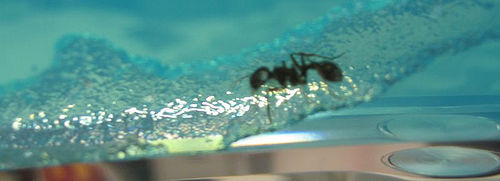

In [48]:
# @title Dataset examples { run: "auto" }

import plotly.express as px
import numpy as np

dataset_path = '/content/ants-bees-dataset/'
vanilla_training_dataset = datasets.ImageFolder(dataset_path + 'train')
class_names = ['A lovely ant', 'What a cute bee']

training_index = 92  #@param {type:"slider", min:0, max:243, step:1}
antbee_example = np.array(vanilla_training_dataset[training_index][0])

fig = px.imshow(antbee_example, title=class_names[vanilla_training_dataset[training_index][1]])
fig.show()

In [49]:
print(f'Samples in the training dataset: {len(vanilla_training_dataset)}')

Samples in the training dataset: 244


The dataset is very small, transfer learning is the only way to go.
Nevertheless we can augment the training dataset, using the image transforms implemented in `torchvision`.



In [50]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),  # this transform perform a different crop every time, de facto augmenting the training dataset
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])  # you have already encountered this transformation two notebooks ago...
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),  # this transform perform always the same crop in the center of the image, we do not want to augment the validation dataset
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

image_datasets = {x: datasets.ImageFolder(os.path.join(dataset_path, x), data_transforms[x]) for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=2) for x in ['train', 'val']}

Let's visualize a transformed example

A transformed training sample of shape (3, 224, 224)



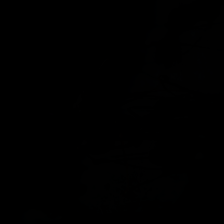

In [55]:
transformed_example =image_datasets['train'][42][0].numpy()
print('A transformed training sample of shape', transformed_example.shape)
fig = px.imshow( np.swapaxes(transformed_example, 0, 2))  # px.imshow wants the color channels as last dimension
fig.show()

> **EXERCISE**: Why is it so black? Have we zoomed too much on an ant with the random crops?
>
>*Hint*: No, look at another tranformation.
>
> Write a function to properly visualize transformed training samples.

In [56]:
# ✏️ your code here

def visualize_samples(batch_of_samples, title=None):
    """
    Visualization of transformed samples, a standard call:
        inputs, classes = next(iter(dataloaders['train']))
        visualize_samples(inputs)
    Arguments:
    batch_of_samples -- a batch from the dataloader; a PyTorch tensor of shape (batch_size, 3, 224, 224)
    title -- (optional) a string with the title of the plot, useful to show the labels

    Return:
    None (A nice plot with )
    """


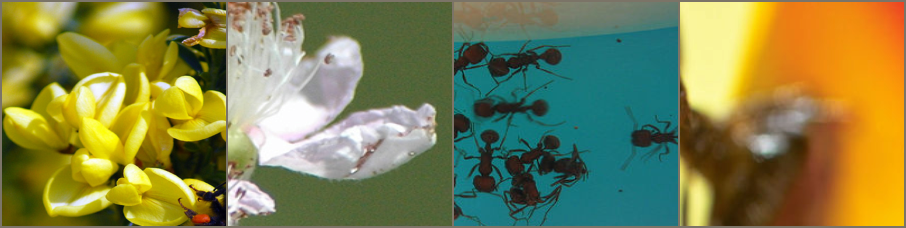

In [57]:
#@title Solution 👀
def visualize_samples(inputs, title=None):
    """
    Visualization of transformed samples, a standard call:
        inputs, classes = next(iter(dataloaders['train']))
        visualize_samples(inputs)
    Arguments:
    batch_of_samples -- a batch from the dataloader; a PyTorch tensor of shape (batch_size, 3, 224, 224)

    Return:
    None (A nice plot)
    """
    
    # Make a grid from batch
    inp = torchvision.utils.make_grid(inputs)

    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)  # plotly accepts the colour information both in the 0-1 range and in the 0-255 range
    fig = px.imshow(inp, title=title)
    fig.show()


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

visualize_samples(inputs, title=f'Ground truth: {[class_names[x] for x in classes]}')

It's time to build our model, we are going to load a pretrained residual convolutional neural network using torchvision.

Since we want to freeze its weigths, we will set their `requires_grad` attribute to `False`.



In [58]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

residual_net = torchvision.models.resnet18(pretrained=True)
for param in residual_net.parameters():
    param.requires_grad = False

# Substitution of the last dense layer
num_ftrs = residual_net.fc.in_features  # input dimension of the last layer
print(f'input dimension of the last layer: {num_ftrs}')
residual_net.fc = nn.Linear(num_ftrs, 2)  # parameters of newly constructed modules have requires_grad=True by default

residual_net = residual_net.to(device)

loss_func = nn.CrossEntropyLoss()

# We optimize only parameters of the last layer
opt = optim.SGD(residual_net.fc.parameters(), lr=0.001, momentum=0.9)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning:

The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning:

Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 205MB/s]

input dimension of the last layer: 512


Let's take a look at our model

In [59]:
from torchsummary import summary

# We have two options

# print(residual_net)  the built-in print do already a nice job, summary from torchsummary organizes all the layers in a nice table 

summary(residual_net, image_datasets['train'][0][0].shape, batch_size=-1)  # -1 is a placeholder for any batch size

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 112, 112]           9,408
       BatchNorm2d-2         [-1, 64, 112, 112]             128
              ReLU-3         [-1, 64, 112, 112]               0
         MaxPool2d-4           [-1, 64, 56, 56]               0
            Conv2d-5           [-1, 64, 56, 56]          36,864
       BatchNorm2d-6           [-1, 64, 56, 56]             128
              ReLU-7           [-1, 64, 56, 56]               0
            Conv2d-8           [-1, 64, 56, 56]          36,864
       BatchNorm2d-9           [-1, 64, 56, 56]             128
             ReLU-10           [-1, 64, 56, 56]               0
       BasicBlock-11           [-1, 64, 56, 56]               0
           Conv2d-12           [-1, 64, 56, 56]          36,864
      BatchNorm2d-13           [-1, 64, 56, 56]             128
             ReLU-14           [-1, 64,

And now let's have a look at the computational graph build by Autograd.
In blue you see the trainable parameters, while in gray the backward functions.

In [60]:
!pip install torchviz

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Preparing metadata (setup.py) ... done
  Created wheel for torchviz: filename=torchviz-0.0.2-py3-none-any.whl size=4147 sha256=3bc62020535f971bb16de0a8c4baa5a205b79bccf92fe2ab438e68027aaaa1b0
  Stored in directory: /root/.cache/pip/wheels/29/65/6e/db2515eb1dc760fecd36b40d54df65c1e18534013f1c037e2e
Successfully built torchviz


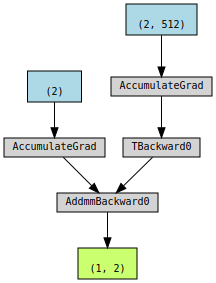

In [61]:
from torchviz import make_dot

x = torch.zeros(1, 3, 224, 224).to(device) #, dtype=torch.float, requires_grad=False)
out = residual_net(x)
make_dot(out)  

Why the computational graph built by Autograd is so small? 


Solution in 

3.

2.

1.

Since our purpose is to sketch the whole model, if we want to do it using the computational graph build by Autograd we have to reactivate the gradients.



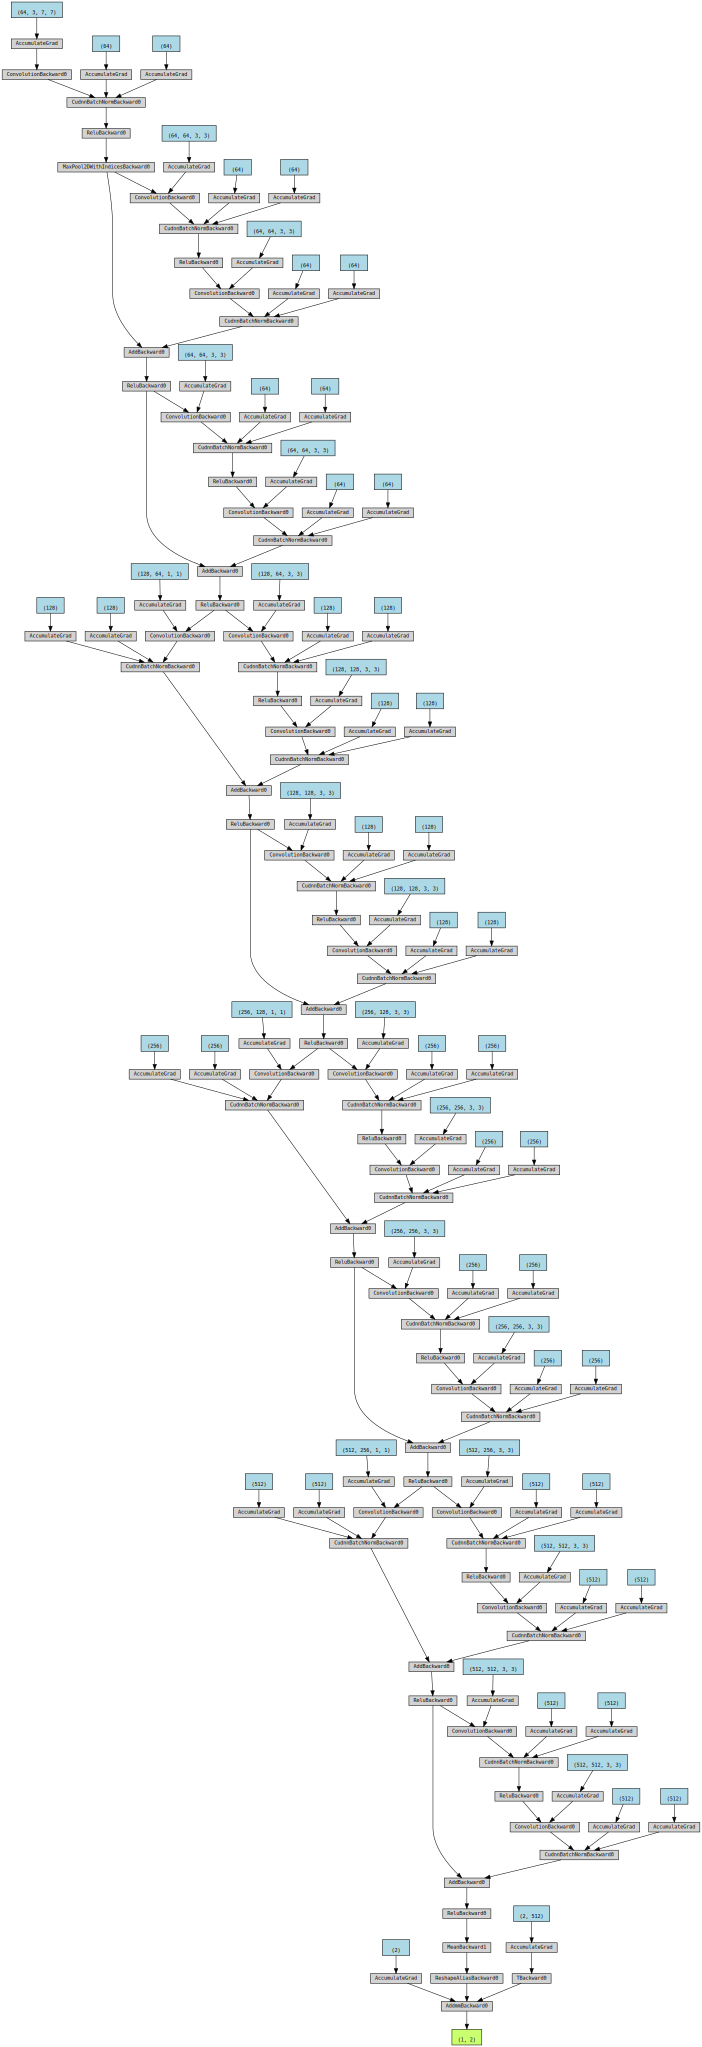

In [62]:
for param in residual_net.parameters():
    param.requires_grad = True
x = torch.zeros(1, 3, 224, 224).to(device) #, dtype=torch.float, requires_grad=False)
out = residual_net(x)
make_dot(out)

Do you see the skip connections?

Finally let's train our model!

In [63]:
# Before training we have to deactivate newly all the gradients except for the last layer
for param in residual_net.parameters():
    param.requires_grad = False
for param in residual_net.fc.parameters():
    param.requires_grad = True

num_epochs = 20

for epoch in range(num_epochs):

    # Evaluation 
    residual_net.eval()
    with torch.no_grad():
        misclassified = {'train': 0, 'val': 0}
        for ds in ['train', 'val']:
            for inputs, classes in dataloaders[ds]:
                inputs = inputs.to(device)
                classes = classes.to(device)
                outputs = residual_net(inputs)
                _, preds = torch.max(outputs, 1)
                misclassified[ds] += np.sum(torch.abs(preds - classes).cpu().numpy())

    accuracy_tr = 1 - misclassified['train'] / len(image_datasets['train'])
    accuracy_val = 1 - misclassified['val'] / len(image_datasets['val'])
    print(f'Epoch: {epoch} \t Training accuracy: {accuracy_tr:.3f} \tValidation accuracy: {accuracy_val:.3f}')

    # Training
    residual_net.train()
    for tr_inputs, tr_classes in dataloaders['train']:
        tr_inputs = tr_inputs.to(device)
        tr_classes = tr_classes.to(device)
        pred = residual_net(tr_inputs)
        loss = loss_func(pred, tr_classes)

        loss.backward()
        opt.step()
        opt.zero_grad()

    


Epoch: 0 	 Training accuracy: 0.516 	Validation accuracy: 0.425
Epoch: 1 	 Training accuracy: 0.934 	Validation accuracy: 0.941
Epoch: 2 	 Training accuracy: 0.939 	Validation accuracy: 0.948
Epoch: 3 	 Training accuracy: 0.955 	Validation accuracy: 0.948
Epoch: 4 	 Training accuracy: 0.848 	Validation accuracy: 0.824
Epoch: 5 	 Training accuracy: 0.939 	Validation accuracy: 0.954
Epoch: 6 	 Training accuracy: 0.934 	Validation accuracy: 0.928
Epoch: 7 	 Training accuracy: 0.959 	Validation accuracy: 0.935
Epoch: 8 	 Training accuracy: 0.914 	Validation accuracy: 0.895
Epoch: 9 	 Training accuracy: 0.926 	Validation accuracy: 0.928
Epoch: 10 	 Training accuracy: 0.951 	Validation accuracy: 0.954
Epoch: 11 	 Training accuracy: 0.967 	Validation accuracy: 0.954
Epoch: 12 	 Training accuracy: 0.963 	Validation accuracy: 0.948
Epoch: 13 	 Training accuracy: 0.963 	Validation accuracy: 0.948
Epoch: 14 	 Training accuracy: 0.963 	Validation accuracy: 0.948
Epoch: 15 	 Training accuracy: 0.92


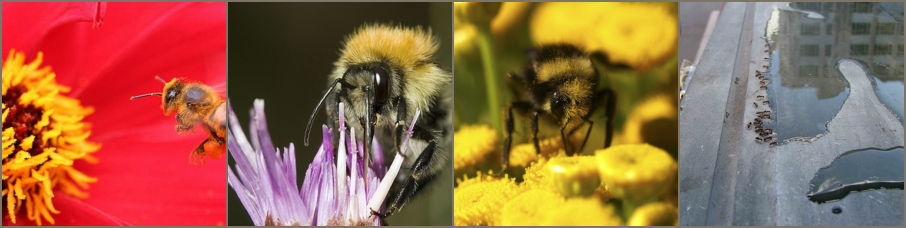

In [65]:
# re-execute to see new examples
inputs, classes = next(iter(dataloaders['val']))
_, predictions = torch.max(residual_net(inputs.to(device)), 1)
visualize_samples(inputs, title=f' ground truth: {[class_names[x] for x in classes]}<br>predictions: {[class_names[x] for x in predictions]}')

*Tutorial on transfer learning adapted from this [tutorial](https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html)*

>**EXERCISE**: Fine tune this model, try to add a [learning rate scheduler](https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate). What happen if you freeze less layers? Try to unfreeze the last residual block. And if you use [another pretrained model](https://pytorch.org/docs/stable/torchvision/models.html) larger than resnet18?